## Genome Generation
Given a number of chromosome pairs and genes, randomly generates chromosomes with genes distributed at random indices throughout.

In [1]:

import random
import string
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import numpy as np
import networkx as nx
from IPython.display import display

def genomecreate(chromosomes=3, total_genes=20, seed=407):
    random.seed(seed)
    
    def distribute_genes(total_genes, chromosomes, min_genes=6):
        while True:
            sizes = [min_genes] * chromosomes
            remaining = total_genes - sum(sizes)
            for _ in range(remaining):
                sizes[random.randint(0, chromosomes - 1)] += 1
            if sum(sizes) == total_genes:
                return sizes

    gene_counts = distribute_genes(total_genes, chromosomes)

    all_genes = list(string.ascii_uppercase[:total_genes])
    random.shuffle(all_genes)

    chromosomes_data = []
    gene_idx = 0

    for chr_num, gene_count in enumerate(gene_counts, 1):
        chr_length = random.randint(1000, 2000)
        gene_names = all_genes[gene_idx:gene_idx + gene_count]

        min_pos = int(chr_length * 0.02)
        max_pos = int(chr_length * 0.98)

        quarter = (max_pos - min_pos) // 4
        required_positions = [
            random.randint(min_pos + i * quarter + 1, min_pos + (i + 1) * quarter)
            for i in range(4)
        ]

        remaining = gene_count - 4
        position_pool = list(range(min_pos, max_pos + 1))
        remaining_positions = random.sample(position_pool, remaining)

        unique_remaining = list(set(remaining_positions) - set(required_positions))
        while len(unique_remaining) < remaining:
            new_pos = random.randint(1, chr_length)
            if new_pos not in required_positions and new_pos not in unique_remaining:
                unique_remaining.append(new_pos)

        positions = sorted(required_positions + unique_remaining[:remaining])
        genes = list(zip(gene_names, positions))

        chrA = [(g, pos) for g, pos in genes]
        chrB = [(g, pos) for g, pos in genes]

        df = pd.DataFrame({
            "Chromosome": f"Chr{chr_num}",
            "Gene": gene_names,
            "Position": positions,
            "ChrA_Before": [g.upper() for g, _ in chrA],
            "ChrB_Before": [g.lower() for g, _ in chrB],
        })

        chromosomes_data.append((f"Chr{chr_num}", df, chr_length))
        gene_idx += gene_count

    return chromosomes_data

In [2]:
def print_genome(genome_data):
    for chr_name, df, chr_length in genome_data:
        print(f"\n=== {chr_name} | Length: {chr_length} bp ===")
        print(df[["Gene", "Position", "ChrA_Before", "ChrB_Before"]].to_string(index=False))

In [3]:
genome=genomecreate(3, 20, 407)
print_genome(genome)


=== Chr1 | Length: 1220 bp ===
Gene  Position ChrA_Before ChrB_Before
   C       234           C           c
   P       347           P           p
   S       485           S           s
   D       624           D           d
   H       715           H           h
   E       998           E           e
   F      1189           F           f

=== Chr2 | Length: 1269 bp ===
Gene  Position ChrA_Before ChrB_Before
   A        99           A           a
   T       516           T           t
   Q       891           Q           q
   B       975           B           b
   G       991           G           g
   N      1228           N           n

=== Chr3 | Length: 1190 bp ===
Gene  Position ChrA_Before ChrB_Before
   I       272           I           i
   K       347           K           k
   O       355           O           o
   L       440           L           l
   M       510           M           m
   R       819           R           r
   J       918           J           j


## Meiosis Simulator
Given a genome, simulates recombination, selection of chromosomes. Returns alleles found on resulting gamete.

In [4]:
def meiosis(chromosomes_data, seed=None):
    if seed is not None:
        random.seed(seed)

    recombinant_data = []

    for chr_name, df, chr_length in chromosomes_data:
        do_recombine = random.random() < 0.5

        if do_recombine:
            crossover = random.randint(1, chr_length)
            swap_above = random.random() < 0.5

            chr1 = list(zip(df["ChrA_Before"], df["Position"]))
            chr2 = list(zip(df["ChrB_Before"], df["Position"]))

            recombinant1 = []
            recombinant2 = []

            for (g1, pos), (g2, _) in zip(chr1, chr2):
                if (swap_above and pos > crossover) or (not swap_above and pos < crossover):
                    recombinant1.append((g2.lower(), pos))
                    recombinant2.append((g1.upper(), pos))
                else:
                    recombinant1.append((g1.upper(), pos))
                    recombinant2.append((g2.lower(), pos))

            df["ChrA_After"] = [g for g, _ in recombinant1]
            df["ChrB_After"] = [g for g, _ in recombinant2]

        else:
            df["ChrA_After"] = df["ChrA_Before"]
            df["ChrB_After"] = df["ChrB_Before"]

        recombinant_data.append((chr_name, None, None, df, chr_length))

    gamete_alleles = []
    for chr_name, _, _, df, _ in recombinant_data:
        selected = df["ChrA_After"] if random.random() < 0.5 else df["ChrB_After"]
        sorted_alleles = [allele for _, allele in sorted(zip(df["Position"], selected))]
        gamete_alleles.extend(sorted_alleles)

    return ",".join(sorted(gamete_alleles, key=str.lower))


## Reproduction
Given two gametes, returns the resulting offspring genotype

In [5]:
def fertilization(gamete1, gamete2):
    alleles1 = gamete1.split(",")
    alleles2 = gamete2.split(",")

    allele_dict = {}

    for a in alleles1 + alleles2:
        base = a.lower()
        if base not in allele_dict:
            allele_dict[base] = []
        allele_dict[base].append(a)

    child_genotype = []
    for base in sorted(allele_dict.keys()):
        pair = allele_dict[base]
        if len(pair) == 1:
            pair.append(pair[0])
        sorted_pair = sorted(pair, key=lambda x: (x.islower(), x))
        child_genotype.append("".join(sorted_pair))

    return "/".join(child_genotype)

In [6]:
genotypes=[]

for _ in range(2000):
    g1 = meiosis(genome)
    genotype = fertilization(g1,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t")
    genotypes.append(genotype)
    df_genotypes = pd.DataFrame(genotypes, columns=["Genotype"])

print(df_genotypes.head())

                                            Genotype
0  aa/bb/cc/dd/ee/ff/gg/hh/Ii/Jj/Kk/Ll/Mm/nn/Oo/p...
1  aa/bb/Cc/Dd/Ee/Ff/gg/Hh/Ii/jj/kk/ll/mm/Nn/oo/P...
2  Aa/bb/Cc/Dd/Ee/Ff/gg/Hh/Ii/jj/Kk/Ll/Mm/nn/Oo/P...
3  aa/Bb/cc/dd/ee/ff/Gg/hh/ii/Jj/kk/ll/mm/Nn/oo/p...
4  Aa/Bb/cc/dd/ee/ff/Gg/hh/Ii/jj/Kk/Ll/Mm/Nn/Oo/p...


In [7]:
genotypes2=[]

for _ in range(1000):
    g1 = meiosis(genome)
    g2=meiosis(genome)
    genotype = fertilization(g1,g2)
    genotypes2.append(genotype)
    df_genotypes2 = pd.DataFrame(genotypes2, columns=["Genotype"])

/tmp/ipykernel_1859/499384312.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_split.applymap(encode_genotype)


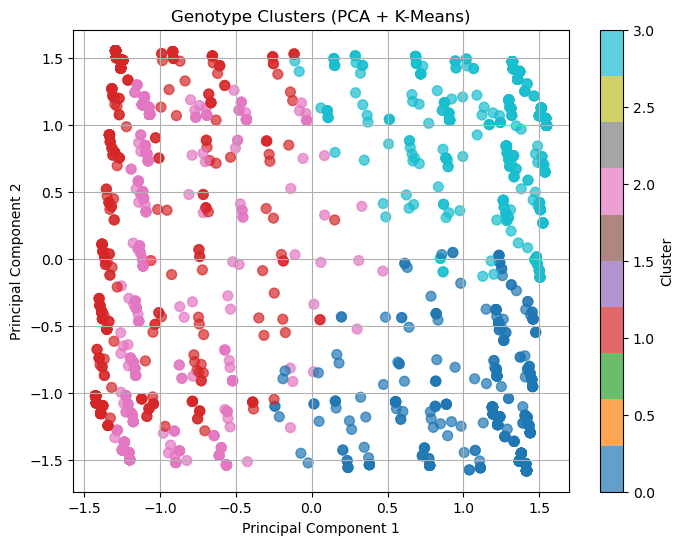

In [8]:
df_split = df_genotypes["Genotype"].str.split("/", expand=True)
df_split.columns = [f"G{i+1}" for i in range(df_split.shape[1])]

def encode_genotype(g):
    g = ''.join(sorted(g, key=str.lower)) 
    if g[0].isupper() and g[1].isupper():
        return 2  
    elif g[0].islower() and g[1].islower():
        return 0 
    else:
        return 1  

df_encoded = df_split.applymap(encode_genotype)

pca = PCA(n_components=2)
components = pca.fit_transform(df_encoded)

k = 4  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_encoded)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    components[:, 0],
    components[:, 1],
    c=clusters,
    cmap="tab10",  
    s=50,
    alpha=0.7
)

plt.title("Genotype Clusters (PCA + K-Means)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()

In [9]:
from IPython.display import display, HTML

def calculate_recombination_frequency(data, i, j):
    recombinants = 0
    total = 0

    for genotype in data:
        genes = genotype.split("/")
        g1 = ''.join(sorted(genes[i], key=str.lower))
        g2 = ''.join(sorted(genes[j], key=str.lower))

        het1 = g1[0] != g1[1]
        het2 = g2[0] != g2[1]

        if het1 != het2:  
            recombinants += 1

        total += 1

    return recombinants / total if total else 0.0
    
def compute_recombination_matrix(df_genotypes):
    genotypes = df_genotypes["Genotype"].tolist()
    num_loci = len(genotypes[0].split("/"))
    loci_labels = list(string.ascii_uppercase)[:num_loci]

    matrix = pd.DataFrame(index=loci_labels, columns=loci_labels, dtype=float)

    for i in range(num_loci):
        for j in range(num_loci):
            if i == j:
                matrix.iloc[i, j] = 0.0
            elif pd.isna(matrix.iloc[i, j]):
                r = calculate_recombination_frequency(genotypes, i, j)
                matrix.iloc[i, j] = r
                matrix.iloc[j, i] = r  

    return matrix

In [10]:
recomb_matrix = 100*compute_recombination_matrix(df_genotypes)
recomb_matrix = recomb_matrix.astype(float)
print(recomb_matrix.values.dtype) 
display(recomb_matrix.round(3))

float64


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
A,0.00,36.20,52.25,51.40,51.30,50.20,36.75,51.60,49.90,50.95,50.65,50.95,51.05,45.85,50.75,51.45,32.45,51.15,51.05,18.00
B,36.20,0.00,50.85,50.90,51.60,51.90,0.55,51.10,48.80,48.95,48.85,48.55,49.05,9.65,48.95,51.35,3.75,48.95,51.55,18.20
C,52.25,50.85,0.00,16.45,31.75,39.25,51.00,20.35,50.25,51.40,50.30,50.30,49.90,50.20,50.10,4.20,50.90,50.90,9.70,51.65
D,51.40,50.90,16.45,0.00,15.30,22.80,50.95,3.90,48.60,50.15,48.75,48.95,48.15,50.05,48.75,12.25,50.95,49.65,6.75,51.10
E,51.30,51.60,31.75,15.30,0.00,7.50,51.65,11.40,49.50,50.55,49.85,50.45,49.55,50.55,49.95,27.55,51.25,50.35,22.05,51.10
F,50.20,51.90,39.25,22.80,7.50,0.00,51.95,18.90,48.60,49.15,48.85,49.25,48.65,51.15,48.85,35.05,51.55,48.95,29.55,50.90
G,36.75,0.55,51.00,50.95,51.65,51.95,0.00,51.05,48.35,48.60,48.40,48.10,48.60,9.10,48.50,51.50,4.30,48.50,51.70,18.75
H,51.60,51.10,20.35,3.90,11.40,18.90,51.05,0.00,49.40,50.75,49.55,49.95,48.95,50.25,49.55,16.15,50.95,50.45,10.65,51.80
I,49.90,48.80,50.25,48.60,49.50,48.60,48.35,49.40,0.00,27.45,3.45,6.95,10.25,48.55,3.75,49.55,48.45,23.25,48.95,48.90
J,50.95,48.95,51.40,50.15,50.55,49.15,48.60,50.75,27.45,0.00,24.00,20.50,17.20,48.20,23.70,51.50,48.80,4.20,51.50,50.55


In [11]:
def group_loci_by_linkage(recomb_matrix, threshold=46):
    G = nx.Graph()
    loci = list(recomb_matrix.columns)

    G.add_nodes_from(loci)

    for i in range(len(loci)):
        for j in range(i + 1, len(loci)):  
            locus1 = loci[i]
            locus2 = loci[j]
            r_val = recomb_matrix.loc[locus1, locus2]
            if r_val <= threshold:
                G.add_edge(locus1, locus2)
                print(f"Linking {locus1}-{locus2} with r={r_val:.3f}")

    groups = list(nx.connected_components(G))
    return groups
    
def get_chromosome_matrices(recomb_matrix, groups):
    chrom_matrices = {}
    for idx, group in enumerate(groups, 1):
        group = sorted(group)
        submatrix = recomb_matrix.loc[group, group]
        chrom_matrices[f"Chr{idx}"] = submatrix.round(1)
    return chrom_matrices
    
def display_chromosome_matrices(chrom_matrices):
    html_blocks = []
    for chr_name, matrix in chrom_matrices.items():
        html = f"<h4>{chr_name}</h4>" + matrix.to_html()
        wrapped = f"<div style='display: inline-block; margin-right: 30px; vertical-align: top'>{html}</div>"
        html_blocks.append(wrapped)

    display(HTML(''.join(html_blocks)))

In [12]:
groups = group_loci_by_linkage(recomb_matrix)
chrom_matrices = get_chromosome_matrices(recomb_matrix, groups)
display_chromosome_matrices(chrom_matrices)


Linking A-B with r=36.200
Linking A-G with r=36.750
Linking A-N with r=45.850
Linking A-Q with r=32.450
Linking A-T with r=18.000
Linking B-G with r=0.550
Linking B-N with r=9.650
Linking B-Q with r=3.750
Linking B-T with r=18.200
Linking C-D with r=16.450
Linking C-E with r=31.750
Linking C-F with r=39.250
Linking C-H with r=20.350
Linking C-P with r=4.200
Linking C-S with r=9.700
Linking D-E with r=15.300
Linking D-F with r=22.800
Linking D-H with r=3.900
Linking D-P with r=12.250
Linking D-S with r=6.750
Linking E-F with r=7.500
Linking E-H with r=11.400
Linking E-P with r=27.550
Linking E-S with r=22.050
Linking F-H with r=18.900
Linking F-P with r=35.050
Linking F-S with r=29.550
Linking G-N with r=9.100
Linking G-Q with r=4.300
Linking G-T with r=18.750
Linking H-P with r=16.150
Linking H-S with r=10.650
Linking I-J with r=27.450
Linking I-K with r=3.450
Linking I-L with r=6.950
Linking I-M with r=10.250
Linking I-O with r=3.750
Linking I-R with r=23.250
Linking J-K with r=24.000

In [13]:
import numpy as np
from scipy.optimize import basinhopping
from itertools import combinations

def map_genes(chrom_matrix):
    loci = chrom_matrix.columns.tolist()
    n = len(loci)
    
    pairs = list(combinations(range(n), 2))
    

    D = np.array([chrom_matrix.iloc[i, j] for i, j in pairs])
    
    def reconstruction_loss(x):
        return sum(abs((abs(x[i] - x[j]) - D[idx])) for idx, (i, j) in enumerate(pairs))

    bounds = [(2, 48)] * n
    x0 = np.random.uniform(2, 48, size=n)

   
    minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}
    result = basinhopping(reconstruction_loss, x0, minimizer_kwargs=minimizer_kwargs, niter=1000)
    x_recovered = result.x

    print("Mapped positions:")
    for gene, pos in zip(loci, np.round(x_recovered, 2)):
         print(f"{gene}: {pos} cM")
    print("\nTotal absolute error:", round(result.fun, 3))
    
    return x_recovered
    

In [14]:
map_genes(chrom_matrices["Chr1"])
map_genes(chrom_matrices["Chr2"])
map_genes(chrom_matrices["Chr3"])

Mapped positions:
A: 2.0 cM
B: 30.01 cM
G: 29.51 cM
N: 20.41 cM
Q: 33.81 cM
T: 48.0 cM

Total absolute error: 74.4
Mapped positions:
C: 34.96 cM
D: 18.56 cM
E: 3.26 cM
F: 45.9 cM
H: 14.66 cM
P: 30.76 cM
S: 25.26 cM

Total absolute error: 109.5
Mapped positions:
I: 39.51 cM
J: 12.11 cM
K: 36.11 cM
L: 32.61 cM
M: 29.31 cM
O: 35.81 cM
R: 16.31 cM

Total absolute error: 0.2


array([39.51249032, 12.11249032, 36.11249032, 32.61249032, 29.31249032,
       35.81249032, 16.31249032])